In [6]:
from transformers import QuestionAnsweringPipeline, AutoAdapterModel, AutoModelWithHeads, AutoTokenizer, AutoConfig
from transformers.onnx import OnnxConfig, validate_model_outputs, export
from transformers.models.bert import BertOnnxConfig

import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType
from onnxruntime import InferenceSession
import onnxruntime

from onnx_opcounter import calculate_params

import os
import time
import torch
import numpy as np

from datasets import load_metric, load_dataset

from typing import Mapping, OrderedDict
from pathlib import Path
import random
import pandas as pd

### Extractive QA (DROP BERT)

In [2]:
# Basic extractive QA Example
question = "What is Mary's job?"
context = "Thomas likes animals. Mary likes strawberry ice and is a physician"

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelWithHeads.from_pretrained("bert-base-uncased")
adapter_name = model.load_adapter("AdapterHub/bert-base-uncased-pf-drop", source="hf")
model.active_adapters = adapter_name

def base_model_inference(question, context):
    inputs = tokenizer(question, context, padding=True, truncation=True, return_tensors="pt")
    
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    start_idx = torch.argmax(outputs.start_logits, axis=1).numpy()[0]
    end_idx = (torch.argmax(outputs.end_logits, axis=1) + 1).numpy()[0]
    return tokenizer.decode(inputs['input_ids'][0, start_idx:end_idx])

answer = base_model_inference(question, context)
print(answer)

/Users/michaelhermann/Source/DASP/code/dasp_onnx/adapterhub_env/lib/python3.9/site-packages/transformers/adapters/models/bert/adapter_model.py:250: FutureWarning: This class has been renamed to `BertAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  warnings.warn(
/Users/michaelhermann/Source/DASP/code/dasp_onnx/adapterhub_env/lib/python3.9/site-packages/transformers/adapters/models/bert/adapter_model.py:228: FutureWarning: This class has been renamed to `BertAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModelWithHeads: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias',

physician


In [118]:
# Export to ONNX with custom config
class DropBertOnnxConfig(OnnxConfig):
    @property
    def inputs(self) -> Mapping[str, Mapping[int, str]]:
        if self.task == "multiple-choice":
            dynamic_axis = {0: "batch", 1: "choice", 2: "sequence"}
        else:
            dynamic_axis = {0: "batch", 1: "sequence"}
        return OrderedDict(
            [
                ("input_ids", dynamic_axis),
                ("attention_mask", dynamic_axis),
                ("token_type_ids", dynamic_axis),
            ]
        )

config = AutoConfig.from_pretrained("bert-base-uncased")
onnx_config = DropBertOnnxConfig(config, task="question-answering")

onnx_path = Path("onnx/dropbert/model.onnx")

onnx_inputs, onnx_outputs = export(tokenizer, model, onnx_config, onnx_config.default_onnx_opset, onnx_path)

onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)

/Users/michaelhermann/Source/DASP/code/dasp_onnx/adapterhub_env/lib/python3.9/site-packages/transformers/adapters/layer.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if context.output_adapter_gating_scores:
/Users/michaelhermann/Source/DASP/code/dasp_onnx/adapterhub_env/lib/python3.9/site-packages/transformers/adapters/composition.py:202: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if tensor is not None and hidden_states.shape[0] != tensor.shape[0]:
/Users/michaelhermann/Source/DASP/code/dasp_onnx/adapterhub_env/lib/python3.9/site-packages/tra

In [119]:
# ONNX model inference
def onnx_inference(onnx_path, question, context):
    onnx_model = onnxruntime.InferenceSession(
        str(onnx_path), providers=["CPUExecutionProvider"]
    )

    inputs = tokenizer(question, context, padding=True, truncation=True, return_tensors="np")
    inputs = {key: np.array(inputs[key], dtype=np.int64) for key in inputs}
    outputs = onnx_model.run(input_feed=dict(inputs), output_names=None)

    start_scores = outputs[0]
    end_scores = outputs[1]
    ans_start = np.argmax(start_scores)
    ans_end = np.argmax(end_scores)+1
    return tokenizer.decode(inputs['input_ids'][0, ans_start:ans_end])

question = 'Where do I live?'
context = 'My name is Paul and I live next to Darmstadt'

answer = onnx_inference(onnx_path, question, context)
print(answer)

next to darmstadt


### Model Quantization

In [120]:
# Quantize base model
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/(1024*1024))
    os.remove('temp.p')

print_size_of_model(model)
print_size_of_model(quantized_model)

Size (MB): 421.1566400527954
Size (MB): 396.7126741409302


In [121]:
def quantize_onnx_model(onnx_model_path, quantized_model_path):
    quantize_dynamic(onnx_model_path,
                     quantized_model_path,
                     weight_type=QuantType.QInt8)

    print(f"Quantized model saved to:{quantized_model_path}")

quantize_onnx_model('onnx/dropbert/model.onnx', 'onnx/dropbert/model_quant.onnx')

print('ONNX full precision model size (MB):', os.path.getsize("onnx/dropbert/model.onnx")/(1024*1024))
print('ONNX quantized model size (MB):', os.path.getsize("onnx/dropbert/model_quant.onnx")/(1024*1024))

Ignore MatMul due to non constant B: /[/bert/encoder/layer.0/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.0/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.1/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.1/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.2/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.2/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.3/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.3/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.4/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.4/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.5/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.5/atten

In [122]:
print('Number of base model params:', model.num_parameters())

def count_params_onnx(model_path):
    onnx_model = onnx.load(model_path)
    params = calculate_params(onnx_model)
    return params

print("ONNX number of full precision model params:", count_params_onnx("onnx/dropbert/model.onnx"))
print("ONNX number of quantized model params:", count_params_onnx("onnx/dropbert/model_quant.onnx"))

Number of base model params: 110378306
ONNX number of full precision model params: 109788226
ONNX number of quantized model params: 109788758.0


### Measure Performance on Dataset

In [7]:
def run_n_times(func, model, inputs, n = 50): 
    st= time.time()
    for _ in range(n):
        func(model, inputs)
    et = time.time()

    avg_inference_time = 1000 * (et - st) / n
    # message = "Average inference time for %s (n=%d): %.2fms " % (desc, n, avg_inference_time)
    
    return avg_inference_time

def run_torch(model, inputs):
    try:
        with torch.no_grad():
            model(**inputs)
    except:
        pass

def run_onnx(qa_model, onnx_inputs):
    try:
        qa_model.run(output_names=["start_logits", "end_logits"], input_feed=dict(onnx_inputs))   
    except:
        pass

In [8]:
data = load_dataset("squad", split='validation')

Found cached dataset squad (/Users/michaelhermann/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


In [9]:
onnx_model = onnxruntime.InferenceSession("onnx/dropbert/model.onnx", providers=["CPUExecutionProvider"])

so = onnxruntime.SessionOptions()
so.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_ALL
opt_session_onnx = onnxruntime.InferenceSession("onnx/dropbert/model.onnx", so)

onnx_model_quant = onnxruntime.InferenceSession("onnx/dropbert/model_quant.onnx", providers=["CPUExecutionProvider"])

so_quant = onnxruntime.SessionOptions()
so_quant.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_ALL
opt_session_onnx_quant = onnxruntime.InferenceSession("onnx/dropbert/model_quant.onnx", so_quant)


In [10]:
def save_df(df_new):
    path_to_logger_file = "logger.csv"
    if os.path.exists(path_to_logger_file):
        df_fin = pd.concat([pd.read_csv(path_to_logger_file), df_new])
        df_fin.to_csv(path_to_logger_file,index=False)
    else: 
        df_new.to_csv(path_to_logger_file,index=False)

In [19]:
import matplotlib.pyplot as plt

def performance_all(perf_type, name, model):
    print(f"Starting: {name}")
    X = []
    time_measurements = []
    df = pd.DataFrame(columns=["model_name", "time once (ms)", "average_time 50 times (ms)", "seq_length", "context", "question", "data_id"])
    

    for i in range(0, len(data["context"]), 25):
        
        context = data["context"][i]
        question = data["question"][i]

        # check if seq too long
        if len(context.split()) > 490: continue

    # for i in range(6):
    #     context = (100*i+1)*"World "
    #     question = "Hello"
    

        if perf_type == "base":
            inputs = tokenizer(question, context, return_tensors="pt")
            time_once = run_n_times(run_torch, model, inputs, 1)
            # average_time = run_n_times(run_torch, model, inputs, 50)
            
        elif perf_type == "seq_length":
            inputs = tokenizer(question, context, return_tensors="np")
            inputs = {key: np.array(inputs[key], dtype=np.int64) for key in inputs}
            time_once = run_n_times(run_onnx, model, inputs, 1) # just run once
            # average_time = run_n_times(run_onnx, model, inputs, 50) # just run once
            
        seq_length = len(context.split()) # TODO -> reduce stopwords? Real Tokenization?
        # print("Input Length {}: {:.3f} ms".format(seq_length, average_time))
        X.append(seq_length)
        # time_measurements.append(average_time)
        average_time = ""
        time_measurements.append(time_once)

        df.loc[len(df)] = [name, time_once, average_time, seq_length, context, question, data["id"][i]]
       
    save_df(df)
    
    plt.scatter(X, time_measurements, label=name)
    print(f"Done: {name}")
    


Starting: DROP BERT Base


Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors


Done: DROP BERT Base
Starting: DROP BERT ONNX


2022-11-30 01:01:42.398302 [E:onnxruntime:, sequential_executor.cc:369 Execute] Non-zero status code returned while running Add node. Name:'/bert/embeddings/Add_1' Status Message: /Users/runner/work/1/s/onnxruntime/core/providers/cpu/math/element_wise_ops.h:523 void onnxruntime::BroadcastIterator::Append(ptrdiff_t, ptrdiff_t) axis == 1 || axis == largest was false. Attempting to broadcast an axis by a dimension other than 1. 512 by 518



Done: DROP BERT ONNX
Starting: DROP BERT ONNX - OPT


2022-11-30 01:02:47.034101 [E:onnxruntime:, sequential_executor.cc:369 Execute] Non-zero status code returned while running Add node. Name:'/bert/embeddings/Add_1' Status Message: /Users/runner/work/1/s/onnxruntime/core/providers/cpu/math/element_wise_ops.h:523 void onnxruntime::BroadcastIterator::Append(ptrdiff_t, ptrdiff_t) axis == 1 || axis == largest was false. Attempting to broadcast an axis by a dimension other than 1. 512 by 518



Done: DROP BERT ONNX - OPT
Starting: DROP BERT ONNX Quantized


2022-11-30 01:03:44.857589 [E:onnxruntime:, sequential_executor.cc:369 Execute] Non-zero status code returned while running Add node. Name:'/bert/embeddings/Add_1' Status Message: /Users/runner/work/1/s/onnxruntime/core/providers/cpu/math/element_wise_ops.h:523 void onnxruntime::BroadcastIterator::Append(ptrdiff_t, ptrdiff_t) axis == 1 || axis == largest was false. Attempting to broadcast an axis by a dimension other than 1. 512 by 518



Done: DROP BERT ONNX Quantized
Starting: DROP BERT ONNX Quantized - OPT


2022-11-30 01:04:36.511707 [E:onnxruntime:, sequential_executor.cc:369 Execute] Non-zero status code returned while running Add node. Name:'/bert/embeddings/Add_1' Status Message: /Users/runner/work/1/s/onnxruntime/core/providers/cpu/math/element_wise_ops.h:523 void onnxruntime::BroadcastIterator::Append(ptrdiff_t, ptrdiff_t) axis == 1 || axis == largest was false. Attempting to broadcast an axis by a dimension other than 1. 512 by 518



Done: DROP BERT ONNX Quantized - OPT


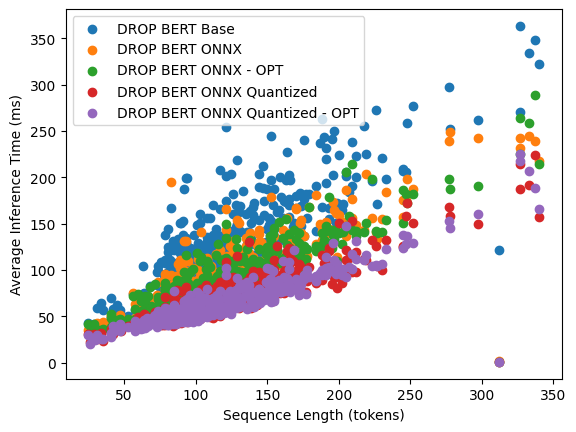

In [20]:
performance_all("base", "DROP BERT Base", model)

performance_all("seq_length", "DROP BERT ONNX", onnx_model)
performance_all("seq_length", "DROP BERT ONNX - OPT", opt_session_onnx)

performance_all("seq_length", "DROP BERT ONNX Quantized", onnx_model_quant)
performance_all("seq_length", "DROP BERT ONNX Quantized - OPT", opt_session_onnx_quant)

plt.xlabel("Sequence Length (tokens)")
plt.ylabel("Average Inference Time (ms)")
plt.legend()
plt.show()

In [21]:
df_log = pd.read_csv("logger.csv")

In [22]:
df_log

,model_name,time once (ms),average_time 50 times (ms),seq_length,context,question,data_id
0,DROP BERT Base,104.720116,109.602637,124,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,56be4db0acb8001400a502ec
1,DROP BERT Base,124.260187,136.236968,140,Other green spaces in the city include the Bot...,Where is a palm house with subtropic plants fr...,573368044776f41900660a2a
2,DROP BERT Base,74.470997,92.508602,103,Teachers that exhibit enthusiasm can lead to s...,What is dramatic gesturing an example of?,56e762fe00c9c71400d77074
3,DROP BERT Base,78.685045,89.804478,90,"As of August 2010, Victoria had 1,548 public s...",How many full time teachers does Victoria have?,570d44abb3d812140066d600
4,DROP BERT Base,101.905823,110.881958,96,Apollo 5 (AS-204) was the first unmanned test ...,"What was the nickname for the test where, duri...",5725e152271a42140099d2d1
...,...,...,...,...,...,...,...
2216,DROP BERT ONNX Quantized - OPT,55.973768,NaN,90,"The notion ""force"" keeps its meaning in quantu...",What type of measurements result under Schrodi...,57377aac1c4567190057447c
2217,DROP BERT ONNX Quantized - OPT,65.988779,NaN,153,What we now call gravity was not identified as...,What is an object's mass proportional to at th...,573784fa1c45671900574487
2218,DROP BERT ONNX Quantized - OPT,56.102753,NaN,121,The origin of electric and magnetic fields wou...,How many vector equations did Heaviside and Gi...,57378e311c456719005744b2
2219,DROP BERT ONNX Quantized - OPT,44.425011,NaN,98,The normal force is due to repulsive forces of...,What is the repulsive force of close range ato...,57379a4b1c456719005744cd


In [9]:
# import matplotlib.pyplot as plt

# def performance_seq_length(name, model):
#     X = []
#     time_measurements = []

#     for i in range(6):
#         context = (100*i+1)*"World "
#         question = "Hello"

#         inputs = tokenizer(question, context, return_tensors="np")
#         inputs = {key: np.array(inputs[key], dtype=np.int64) for key in inputs}
#         average_time = run_n_times(run_onnx, model, inputs)

#         seq_length = 100*i+5
#         print("Input Length {}: {:.3f} ms".format(seq_length, average_time))
#         X.append(seq_length)
#         time_measurements.append(average_time)

#     plt.scatter(X, time_measurements, label=name)

# def base_performance(name, model):
#     X = []
#     time_measurements = []

#     for i in range(6):
#         context = (100*i+1)*"World "
#         question = "Hello"

#         inputs = tokenizer(question, context, return_tensors="pt")
#         average_time = run_n_times(run_torch, model, inputs)
        
#         seq_length = 100*i+5 
#         print("Input Length {}: {:.3f} ms".format(seq_length, average_time))
#         X.append(seq_length)
#         time_measurements.append(average_time)

#     plt.scatter(X, time_measurements, label=name)


# onnx_model = InferenceSession(
#     "onnx/dropbert/model.onnx", providers=["CPUExecutionProvider"]
# )

# onnx_model_quant = InferenceSession(
#     "onnx/dropbert/model_quant.onnx", providers=["CPUExecutionProvider"]
# )

# base_performance("DROP BERT Base", model)
# performance_seq_length("DROP BERT ONNX", onnx_model)
# performance_seq_length("DROP BERT ONNX Quantized", onnx_model_quant)

# plt.xlabel("Sequence Length (tokens)")
# plt.ylabel("Average Inference Time (ms)")
# plt.legend()
# plt.show()

### Multiple-Choice (CosmosQA BERT)

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# model = AutoModelWithHeads.from_pretrained("bert-base-uncased")
# adapter_name = model.load_adapter("AdapterHub/bert-base-uncased-pf-cosmos_qa", source="hf")
# model.active_adapters = adapter_name

# def mc_model_inference(question, context, choices):
#     outputs = []

#     raw_input = [[context, question + " " + choice] for choice in choices]
#     inputs = tokenizer(raw_input, padding=True, truncation=True, return_tensors="pt")

#     with torch.no_grad():
#         outputs = model(**inputs)

#     answer_idx = torch.argmax(outputs.logits)
#     return choices[answer_idx]

# question = "What animal has the most hair?"
# context = "Fish are typically not hairy. Cats have 10g of hair. Tigers have 50g of hair. Horses have 100g of hair."
# answer0 = "Tiger"
# answer1= "Cat"
# answer2= "Horse"
# answer3= "Fish"
# choices = [answer0, answer1, answer2, answer3]
# answer = mc_model_inference(question, context, choices)
# print(answer)

In [ ]:
# config = AutoConfig.from_pretrained("bert-base-uncased")
# onnx_config = DropBertOnnxConfig(config, task="question-answering")

# onnx_path = Path("onnx/cosmosqabert/model.onnx")

# onnx_inputs, onnx_outputs = export(tokenizer, model, onnx_config, onnx_config.default_onnx_opset, onnx_path)

# onnx_model = onnx.load(onnx_path)
# onnx.checker.check_model(onnx_model)

In [ ]:
# def onnx_inference(onnx_path, question, context, choices):
#     onnx_model = InferenceSession(
#         str(onnx_path), providers=["CPUExecutionProvider"]
#     )

#     raw_input = [[context, question + " " + choice] for choice in choices]
#     inputs = tokenizer(raw_input, padding=True, truncation=True, return_tensors="np")

#     outputs = onnx_model.run(input_feed=dict(inputs), output_names=None)

#     answer_idx = np.argmax(np.abs(np.sum(outputs[0], axis=1)))
#     return choices[answer_idx]

# answer = onnx_inference(onnx_path, question, context, choices)
# print(answer)

In [9]:
# def sorter(lst):
#     ls = [0]*len(lst)
#     for i in range(len(lst)):
#         space = 0
#         t = lst[i]
#         for j in t:
#             if j == " ":
#                 space += 1
#         ls[i] = space+1
#     return ls

# def sorting_data(lst):
#     lst.sort(key=len)
#     return lst

# def sorting_data2(lst):
#     h = [i.split() for i in lst]
#     m =  sorted(h, key=len)
#     return [" ".join(n) for n in m]
    
# def get_question(sorted_context_set_index, set_of_sorted_context_list):
#     original_index = data["context"].index(set_of_sorted_context_list[sorted_context_set_index])
#     return data["question"][original_index]

# def get_random_indexes_list(amount=41, intervals=50): #  2067 unique indexes
#     max = 2066 # TODO
#     index_list = []
#     for i in range(amount):
#         rand_index = random.randint(i*intervals, (i+1)*intervals)
#         if rand_index > max:
#             rand_index = max
#         index_list.append(rand_index)
#     return index_list

# def get_specific_indexes_list(start, intervals):
#     max = 2066 # TODO
#     index_list = []
#     for i in range(start, max, intervals):
#         rand_index = random.randint(i, i+intervals)
#         if rand_index > max:
#             rand_index = max
#         index_list.append(rand_index)
#     return index_list

In [ ]:
# import matplotlib.pyplot as plt


# # Idea - > only use each context once. still > 2k unique contexts 
# # but also uses only of multiple questions
# sorted_context_list = sorting_data(data["context"])
# set_of_sorted_context_list = sorting_data(list(set(sorted_context_list)))

# def performance(perf_type, name, model, random_indexes):
#     X = []
#     time_measurements = []

#     for random_index in random_indexes:

#         context = set_of_sorted_context_list[random_index]
#         question = get_question(random_index, set_of_sorted_context_list)  


#         if perf_type == "base":
#             inputs = tokenizer(question, context, return_tensors="pt")
#             average_time = run_n_times(run_torch, model, inputs)
#         elif perf_type == "seq_length":
#             inputs = tokenizer(question, context, return_tensors="np")
#             inputs = {key: np.array(inputs[key], dtype=np.int64) for key in inputs}
#             average_time = run_n_times(run_onnx, model, inputs)
            
#         seq_length = len(context.split()) # TODO -> reduce stopwords? Real Tokenization?
#         print("Input Length {}: {:.3f} ms".format(seq_length, average_time))
#         X.append(seq_length)
#         time_measurements.append(average_time)

#     plt.scatter(X, time_measurements, label=name)